In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define your network
class CustomNeuralNetwork(nn.Module):  # 继承nn.module 类，只需自己定义数据如何输入
    def __init__(self, layers):  #layers:  list, 每个元素为每层的神经元个数，第一个为输入维度，最后一个为输出维度
        super(CustomNeuralNetwork, self).__init__()  

        net_layers = []

        for i in range(1, len(layers)):
            net_layers.append(nn.Linear(layers[i-1], layers[i]))
            if i < len(layers) - 1:  # 最后一层不需要激活函数
                net_layers.append(nn.ReLU())  # You can use other activation functions here

        self.net = nn.Sequential(*net_layers)   # 把list中的元素依次嵌套成网络
        

    def forward(self, x):
        return self.net(x)

# Define your data
# Assuming you have input_data as a NumPy array with shape (num_samples, num_features)
# and target_data as a NumPy array with shape (num_samples, 1)
input_data = np.random.rand(100, 5)
target_data = np.random.rand(100, 1)

# Convert NumPy arrays to PyTorch tensors
input_data = torch.Tensor(input_data)
target_data = torch.Tensor(target_data)

# Specify the dimensions of your data
input_size = input_data.shape[1]  # Number of features
output_size = 1  # Output is a single number

# Define the network
layers = [input_size, 10, 10, output_size]  # 层数可调
model = CustomNeuralNetwork(layers)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate

# Training the network
num_epochs = 1000  # You can adjust the number of epochs
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(input_data)
    loss = criterion(outputs, target_data)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# The model is now trained and can be used for predictions


Epoch [100/1000], Loss: 0.0974
Epoch [200/1000], Loss: 0.0898
Epoch [300/1000], Loss: 0.0860
Epoch [400/1000], Loss: 0.0835
Epoch [500/1000], Loss: 0.0819
Epoch [600/1000], Loss: 0.0809
Epoch [700/1000], Loss: 0.0801
Epoch [800/1000], Loss: 0.0777
Epoch [900/1000], Loss: 0.0707
Epoch [1000/1000], Loss: 0.0633


In [ ]:
# 自定义参数

self.lambda_param = nn.Parameter(torch.tensor(0.5), requires_grad=True)

# 求导
grad_y = torch.autograd.grad(y, x, create_graph=True)  # Create a graph suitable for further gradient computation
# Now, compute the second-order gradient (Hessian matrix)
second_order_grad_y = torch.autograd.grad(grad_y, x)
#自定义loss
def custom_mae_loss(predicted, target):
    return torch.mean(torch.abs(predicted - target))

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class U_net(nn.Module):
    def __init__(self, layers, params):
        super(U_net, self).__init__()
        self.params = params  
        
        # Define your network layers here
        net_layers = []

        for i in range(1, len(layers)):
            net_layers.append(nn.Linear(layers[i-1], layers[i]))
            if i < len(layers) - 1:
                net_layers.append(nn.ReLU())

        self.U = nn.Sequential(*net_layers)

    def F(self,x_f, t_f):
        # Define your additional operations here
        U_t = torch.autograd.grad(self.U_inner, t_f,torch.ones_like(t_f),create_graph=True)[0]  #ones_like(t_f)使得能计算每一对U_inner和t_f的导数
        
        U_x = torch.autograd.grad(self.U_inner, x_f, torch.ones_like(x_f),create_graph=True)[0]
        
        U_xx = torch.autograd.grad(U_x, x_f, torch.ones_like(x_f),create_graph=True)[0]
       
        return U_t + self.U_inner * U_x - self.params * U_xx
    

    def forward(self, x_u, t_u, x_f, t_f):
       
        self.U_bound = self.U(torch.cat((x_u, t_u), 1))
        self.U_inner = self.U(torch.cat((x_f, t_f), 1))
        F_output = self.F(x_f, t_f)  # Calculate the result of your additional operations

        return F_output, self.U_bound  # Return both F_output and U_output
    



In [31]:
#load data
import scipy.io
import numpy as np
from pyDOE import lhs
data = scipy.io.loadmat(r'./Data/burgers_shock.mat')

N_u = 100
N_f = 10000
params = 0.01/np.pi

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #（x,t）的所有组合
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)  #（x,t）的最小值
ub = X_star.max(0)  #（x,t）的最大值
    
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #X最小值的边界
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))  #T最小值的边界
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))  #T最大值的边界
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])  #边界点纵向堆叠
X_f_train = lb + (ub-lb)*lhs(2, N_f)  #lhs生成N_f行，2列的随机数,取得Nf个内部点
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False) #从X_u_train中随机选取N_u个点
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]


In [39]:
# Create an instance of your U_net model
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
model = U_net(layers, params)

# Input data
x_bound = torch.Tensor(X_u_train[:,0:1])
t_bound = torch.Tensor(X_u_train[:,1:2])
x_inner = torch.Tensor(X_f_train[:,0:1])
x_inner.requires_grad=True
t_inner = torch.Tensor(X_f_train[:,1:2])
t_inner.requires_grad=True
u_train_tf = torch.Tensor(u_train)
# Forward pass through the model

# Now you can use F_output and U_output in your loss function

# Define an optimizer
optimizer = optim.LBFGS(model.parameters(),max_iter=50000)

def loss_func(F, U):
    return torch.mean(torch.square(F)) + torch.mean(torch.square(U - u_train_tf))
def closure():
    optimizer.zero_grad()
    F_output, U_output = model(x_bound, t_bound, x_inner, t_inner)
    loss = loss_func(F_output, U_output)
    loss.backward()
    return loss
# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    # Calculate the loss
    optimizer.step(closure)
    if (epoch + 1) % 10 == 0:
        loss = closure()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

: 

In [33]:
#predict
from scipy.interpolate import griddata
pred_x = torch.tensor(X_star[:,0:1],dtype=torch.float32)
pred_x.requires_grad=True
pred_t = torch.tensor(X_star[:,1:2],dtype=torch.float32)
pred_t.requires_grad=True

F_pred, U_pred = model(pred_x, pred_t, pred_x, pred_t) #计算相同点的F和U
#convert to numpy
U_pred = U_pred.detach().numpy()
U_interp = griddata(X_star, U_pred.flatten(), (X, T), method='cubic')  #把一列重新整理为矩阵


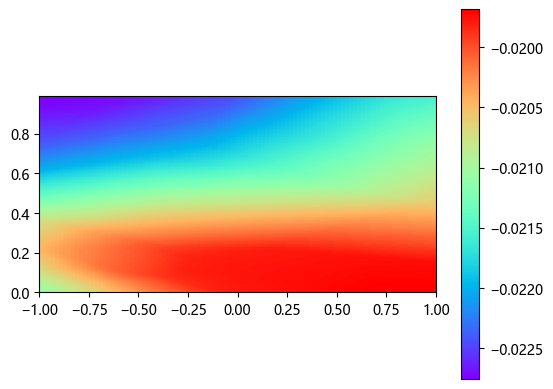

In [35]:

import matplotlib.pyplot as plt


plt.imshow(U_interp.T,interpolation='nearest', origin='lower', cmap='rainbow',extent=[lb[0], ub[0], lb[1], ub[1]])

plt.colorbar()
plt.show()
